In [1]:
import kdataset
import torch
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython
import random
import soundfile as sf

In [2]:
train_path = r'C:\Users\jwjln\Desktop\SVdataset\Data\Training'
test_path = r'C:\Users\jwjln\Desktop\SVdataset\Data\Validation'
df_path = r'C:\Users\jwjln\Desktop\SV\SpeakerVerification\data\file_list'
rir_path = r'C:\Users\jwjln\Desktop\SVdataset\rirs_noises\RIRS_NOISES\simulated_rirs'
musan_path = r'C:\Users\jwjln\Desktop\SVdataset\musan'

max_frame = 300
batch_size = 500
num_workers = 4

train_dataset = kdataset.asv_dataset(
    asv_path=train_path,
    df_path=df_path,
    rir_path =rir_path,
    musan_path =musan_path,
    max_frame=max_frame,
    augment=True,
    train = True
)

Read pkl...

====== Dataset Load Info ======
Number of speakers : 1471
Number of utterances : 5875802

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875802 entries, 0 to 5875801
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   wavfiles  object
 1   labels    int64 
dtypes: int64(1), object(1)
memory usage: 89.7+ MB
None


In [3]:
test_dataset = kdataset.asv_dataset(
    asv_path = test_path,
    df_path = df_path,
    rir_path = None,
    musan_path = None,
    max_frame = max_frame,
    augment = False,
    train = False
)

Read pkl...

====== Dataset Load Info ======
Number of speakers : 507
Number of utterances : 734329

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734329 entries, 0 to 734328
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   wavfiles  734329 non-null  object
 1   labels    734329 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.2+ MB
None


torch.Size([48240])
torch.Size([48240])
torch.Size([48240])


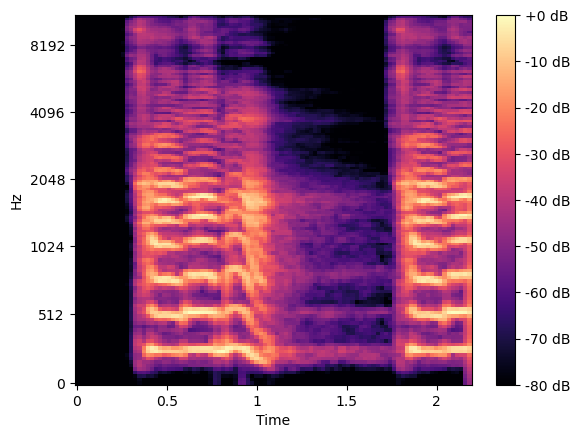

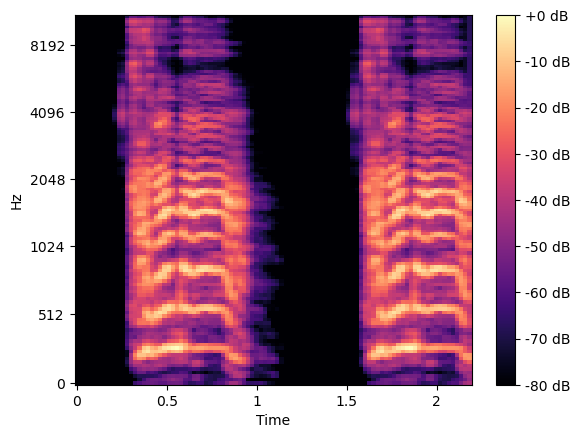

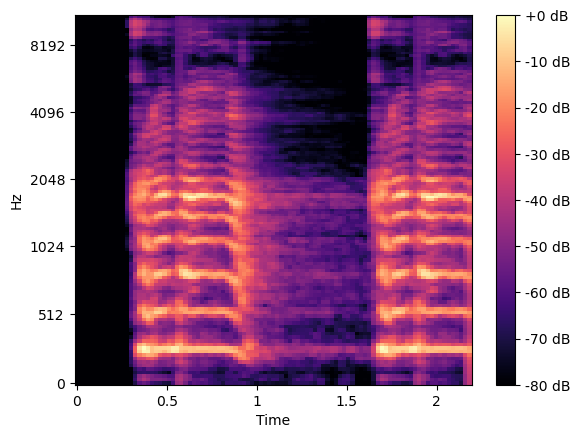

In [3]:
for idx, (audio, label)in enumerate(train_dataset):
    print(audio.shape)
    mel = librosa.feature.melspectrogram(y=audio.numpy(), sr=16000)
    
    fig, ax = plt.subplots()
    mel_db = librosa.power_to_db(mel, ref=np.max)
    img = librosa.display.specshow(mel_db, y_axis='mel', x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    plt.plot()
    
    if idx==2:
        break

In [6]:
IPython.display.Audio(audio.numpy(), rate=16000)

In [8]:
import glob
import os

musan_path = r'C:\Users\jwjln\Desktop\SVdataset\musan'
# for data augmentation
noisetypes = ['noise','speech','music']

noisesnr   = {'noise':[0,15],'speech':[13,20],'music':[5,15]}
numnoise   = {'noise':[1,1], 'speech':[3,7],  'music':[1,1] }
noiselist  = {
    'noise':[],
    'speech':[],
    'music':[]
}

augment_files   = glob.glob(os.path.join(musan_path,'*/*/*/*.wav'))

for file in augment_files:
    noise_type = file.split('\\')[-3] # noise_type :  'noise' or 'speech' or 'music'
    noiselist[noise_type].append(file)

In [6]:
val = max(0.0, np.mean(np.power(audio.numpy(), 2)))
clean_db = 10*np.log10(val+1e-4)

numnoise    = numnoise['speech']
noiselist   = random.sample(noiselist['speech'], random.randint(numnoise[0],numnoise[1]))
audio_length = len(audio)

noises = []

for noise in noiselist:
    # read noise file
    noiseaudio, _  = sf.read(noise) # (noise_length, )
    noiseaudio = noiseaudio.astype(float)
    noise_length = len(noiseaudio)

            # zero-padding for noise to match audio length
    if noise_length <= audio_length:
        shortage = audio_length - noise_length
        noiseaudio = np.pad(noiseaudio, (0, shortage), 'wrap')
        noiseaudio = noiseaudio.astype(float)
    else:
        start_frame = int(random.random()*(noise_length - audio_length))
        noiseaudio = noiseaudio[start_frame:start_frame + audio_length]

            # set snr
    noise_snr   = random.uniform(noisesnr['music'][0],noisesnr['music'][1])
    val = max(0.0, np.mean(np.power(noiseaudio, 2)))
    noise_db = 10*np.log10(val+1e-4)

    noiseaudio = np.sqrt(10 ** ((clean_db - noise_db - noise_snr) / 10)) * noiseaudio
    noises.append(noiseaudio)
    
noise_stack = np.stack(noises,axis=0) # (numnoise, audio_length)
noise_sum = np.sum(noise_stack,axis=0) # (audio_length,)

In [9]:
numnoise    = numnoise['speech']
noiselist1  = random.sample(noiselist['speech'], random.randint(numnoise[0],numnoise[1]))
noiselist1

['C:\\Users\\jwjln\\Desktop\\SVdataset\\musan\\musan\\speech\\us-gov\\speech-us-gov-0132.wav',
 'C:\\Users\\jwjln\\Desktop\\SVdataset\\musan\\musan\\speech\\librivox\\speech-librivox-0004.wav',
 'C:\\Users\\jwjln\\Desktop\\SVdataset\\musan\\musan\\speech\\librivox\\speech-librivox-0041.wav',
 'C:\\Users\\jwjln\\Desktop\\SVdataset\\musan\\musan\\speech\\us-gov\\speech-us-gov-0214.wav',
 'C:\\Users\\jwjln\\Desktop\\SVdataset\\musan\\musan\\speech\\us-gov\\speech-us-gov-0228.wav']

In [10]:
numnoise[0], numnoise[1]

(3, 7)

[]

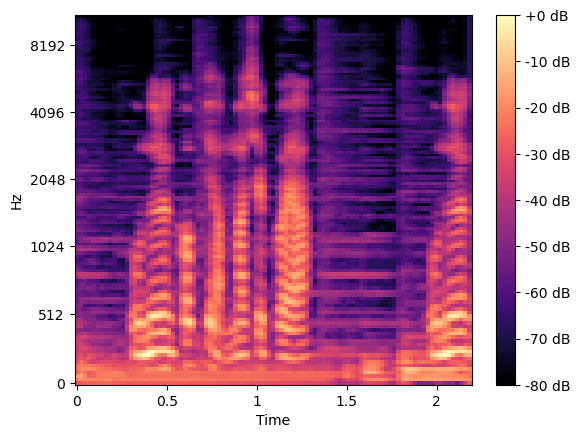

In [31]:
n_aug = noise_sum + audio.numpy()
mel = librosa.feature.melspectrogram(y=n_aug, sr=16000)

fig, ax = plt.subplots()
mel_db = librosa.power_to_db(mel, ref=np.max)
img = librosa.display.specshow(mel_db, y_axis='mel', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.plot()

In [32]:
IPython.display.Audio(n_aug, rate=16000)